In [66]:
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm


In [67]:
BINARY_DIR = '../data/binary/'
RESULT_DIR = '../data/result/'


In [68]:
def detect_boundary(img, hei, wid, t=5):
    data = np.zeros((hei, 5))  # [index, start, end, flag, flag]

    # detection boundary
    for j in range(hei):
        data[j][0] = j  # index

        # detection from left side
        for i in range(wid - t):
            if np.all(img[j][i:i + t] == 255):
                data[j][1] = i
                data[j][3] = 1

                break

        # detection from right side
        if j > 700:
            for i in reversed(range(t, wid)):
                if np.all(img[j][i - t:i] == 255):
                    data[j][2] = i

                    if i > 1200:
                        data[j][4] = 0
                    else:
                        data[j][4] = 1

                    break

    return data


In [69]:
def fitting(data):
    def _parabola_func(_x, *_params):
        _y = np.zeros_like(_x)

        for _i, _param in enumerate(_params):
            _y += np.array(_param * _x ** _i)

        return _y

    a = np.zeros(1)
    b = np.zeros(1)

    for i in range(data.shape[0]):
        # left boundary
        if data[i, 3] == 1:
            a = np.append(a, data[i, 0])
            b = np.append(b, data[i, 1])

        # right boundary
        if data[i, 4] == 1:
            a = np.append(a, data[i, 0])
            b = np.append(b, data[i, 2])

    popt, pcov = curve_fit(_parabola_func, b[1:], a[1:], p0=[1, 1, 1])
    perr = np.sqrt(np.diag(pcov))

    return popt, perr


In [70]:
def analysis():
    # set params
    U = [175, 200, 225, 250]
    Q = [215, 304, 429]
    D = [18, 24, 30]

    length = 10
    x1, y1 = 505, 447
    x2, y2 = 506, 530
    z = length / np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    # get a
    a_list = np.zeros(0)
    e_list = np.zeros(0)

    for u in tqdm(U):
        for q in Q:
            for d in D:
                # read mask img
                bin_img = cv2.imread(BINARY_DIR + f'b_u_{u}_q_{q}_d_{d}_ppm_0.bmp', 0)

                # detect boundary
                boundary = detect_boundary(img=bin_img, hei=1024, wid=1280)

                # parabola fitting
                p, pe = fitting(boundary)

                # save tmp result
                a_list = np.append(a_list, -p[2] / z)
                e_list = np.append(e_list, -pe[2] / z)

    # save result
    np.savetxt(RESULT_DIR + 'parabola_fitting_result.csv', np.array([a_list, e_list]), delimiter=',')


In [71]:
def load_result():
    return np.loadtxt(RESULT_DIR + 'parabola_fitting_result.csv', delimiter=',')


In [72]:
def graph_qa_d_180(a_list, e_list):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.xlabel('$\it{Q}$ [L/min]', fontsize=32)
    plt.ylabel('$\it{a}$ [mm$^{-1}$]', fontsize=32)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    ax.xaxis.label.set_color('w')
    ax.yaxis.label.set_color('w')
    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')
    plt.xlim(0, 4.5)
    plt.ylim(0, 0.03)

    plt.grid(zorder=9)

    # u = 175
    plt.scatter(2.15, a_list[0], s=400, marker=',', color='y', zorder=10, label='175')
    plt.scatter(3.04, a_list[3], s=400, marker=',', color='y', zorder=10)
    plt.scatter(4.29, a_list[6], s=400, marker=',', color='y', zorder=10)

    plt.errorbar(2.15, a_list[0], yerr=e_list[0], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[3], yerr=e_list[3], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[6], yerr=e_list[6], capsize=18, capthick=3, ecolor='black')

    # u = 200
    plt.scatter(2.15, a_list[9], s=400, marker='o', color='m', zorder=10, label='200')
    plt.scatter(3.04, a_list[12], s=400, marker='o', color='m', zorder=10)
    plt.scatter(4.29, a_list[15], s=400, marker='o', color='m', zorder=10)

    plt.errorbar(2.15, a_list[9], yerr=e_list[9], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[12], yerr=e_list[12], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[15], yerr=e_list[15], capsize=18, capthick=3, ecolor='black')

    # u = 225
    plt.scatter(2.15, a_list[18], s=400, marker='^', color='c', zorder=10, label='225')
    plt.scatter(3.04, a_list[21], s=400, marker='^', color='c', zorder=10)
    plt.scatter(4.29, a_list[24], s=400, marker='^', color='c', zorder=10)

    plt.errorbar(2.15, a_list[18], yerr=e_list[18], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[21], yerr=e_list[21], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[24], yerr=e_list[24], capsize=18, capthick=3, ecolor='black')

    # u = 250
    plt.scatter(2.15, a_list[27], s=400, marker='D', color='k', zorder=10, label='250')
    plt.scatter(3.04, a_list[30], s=400, marker='D', color='k', zorder=10)
    plt.scatter(4.29, a_list[33], s=400, marker='D', color='k', zorder=10)

    plt.errorbar(2.15, a_list[27], yerr=e_list[27], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[30], yerr=e_list[30], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[33], yerr=e_list[33], capsize=18, capthick=3, ecolor='black')

    plt.legend(loc='upper left', fontsize=32)

    plt.show()

def graph_qa_d_240(a_list, e_list):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.xlabel('$\it{Q}$ [L/min]', fontsize=32)
    plt.ylabel('$\it{a}$ [mm$^{-1}$]', fontsize=32)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    ax.xaxis.label.set_color('w')
    ax.yaxis.label.set_color('w')
    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')
    plt.xlim(0, 4.5)
    plt.ylim(0, 0.03)

    plt.grid(zorder=9)

    # u = 175
    plt.scatter(2.15, a_list[1], s=400, marker=',', color='y', zorder=10, label='175')
    plt.scatter(3.04, a_list[4], s=400, marker=',', color='y', zorder=10)
    plt.scatter(4.29, a_list[7], s=400, marker=',', color='y', zorder=10)

    plt.errorbar(2.15, a_list[1], yerr=e_list[1], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[4], yerr=e_list[4], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[7], yerr=e_list[7], capsize=18, capthick=3, ecolor='black')

    # u = 200
    plt.scatter(2.15, a_list[10], s=400, marker='o', color='m', zorder=10, label='200')
    plt.scatter(3.04, a_list[13], s=400, marker='o', color='m', zorder=10)
    plt.scatter(4.29, a_list[16], s=400, marker='o', color='m', zorder=10)

    plt.errorbar(2.15, a_list[10], yerr=e_list[10], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[13], yerr=e_list[13], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[16], yerr=e_list[16], capsize=18, capthick=3, ecolor='black')

    # u = 225
    plt.scatter(2.15, a_list[19], s=400, marker='^', color='c', zorder=10, label='225')
    plt.scatter(3.04, a_list[22], s=400, marker='^', color='c', zorder=10)
    plt.scatter(4.29, a_list[25], s=400, marker='^', color='c', zorder=10)

    plt.errorbar(2.15, a_list[19], yerr=e_list[19], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[22], yerr=e_list[22], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[25], yerr=e_list[25], capsize=18, capthick=3, ecolor='black')

    # u = 250
    plt.scatter(2.15, a_list[28], s=400, marker='D', color='k', zorder=10, label='250')
    plt.scatter(3.04, a_list[31], s=400, marker='D', color='k', zorder=10)
    plt.scatter(4.29, a_list[34], s=400, marker='D', color='k', zorder=10)

    plt.errorbar(2.15, a_list[28], yerr=e_list[28], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[31], yerr=e_list[31], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[34], yerr=e_list[34], capsize=18, capthick=3, ecolor='black')

    plt.legend(loc='upper left', fontsize=32)

    plt.show()

def graph_qa_d_300(a_list, e_list):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.xlabel('$\it{Q}$ [L/min]', fontsize=32)
    plt.ylabel('$\it{a}$ [mm$^{-1}$]', fontsize=32)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    ax.xaxis.label.set_color('w')
    ax.yaxis.label.set_color('w')
    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')
    plt.xlim(0, 4.5)
    plt.ylim(0, 0.03)

    plt.grid(zorder=9)

    # u = 175
    plt.scatter(2.15, a_list[2], s=400, marker=',', color='y', zorder=10, label='175')
    plt.scatter(3.04, a_list[5], s=400, marker=',', color='y', zorder=10)
    plt.scatter(4.29, a_list[8], s=400, marker=',', color='y', zorder=10)

    plt.errorbar(2.15, a_list[2], yerr=e_list[2], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[5], yerr=e_list[5], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[8], yerr=e_list[8], capsize=18, capthick=3, ecolor='black')

    # u = 200
    plt.scatter(2.15, a_list[11], s=400, marker='o', color='m', zorder=10, label='200')
    plt.scatter(3.04, a_list[14], s=400, marker='o', color='m', zorder=10)
    plt.scatter(4.29, a_list[17], s=400, marker='o', color='m', zorder=10)

    plt.errorbar(2.15, a_list[11], yerr=e_list[11], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[14], yerr=e_list[14], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[17], yerr=e_list[17], capsize=18, capthick=3, ecolor='black')

    # u = 225
    plt.scatter(2.15, a_list[20], s=400, marker='^', color='c', zorder=10, label='225')
    plt.scatter(3.04, a_list[23], s=400, marker='^', color='c', zorder=10)
    plt.scatter(4.29, a_list[26], s=400, marker='^', color='c', zorder=10)

    plt.errorbar(2.15, a_list[20], yerr=e_list[20], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[23], yerr=e_list[23], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[26], yerr=e_list[26], capsize=18, capthick=3, ecolor='black')

    # u = 250
    plt.scatter(2.15, a_list[29], s=400, marker='D', color='k', zorder=10, label='250')
    plt.scatter(3.04, a_list[32], s=400, marker='D', color='k', zorder=10)
    plt.scatter(4.29, a_list[35], s=400, marker='D', color='k', zorder=10)

    plt.errorbar(2.15, a_list[29], yerr=e_list[29], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(3.04, a_list[32], yerr=e_list[32], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(4.29, a_list[35], yerr=e_list[35], capsize=18, capthick=3, ecolor='black')

    plt.legend(loc='upper left', fontsize=32)

    plt.show()

In [73]:
def graph_ua_d_180(a_list, e_list):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.xlabel('$\it{U}$ [mm/s]', fontsize=32)
    plt.ylabel('$\it{a}$ [mm$^{-1}$]', fontsize=32)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    ax.xaxis.label.set_color('w')
    ax.yaxis.label.set_color('w')
    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')
    plt.xlim(0, 260)
    plt.ylim(0, 0.03)
    # ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
    plt.grid(zorder=9)

    # q = 215
    plt.scatter(175, a_list[0], s=400, marker=',', color='b', zorder=10, label='2.15')
    plt.scatter(200, a_list[9], s=400, marker=',', color='b', zorder=10)
    plt.scatter(225, a_list[18], s=400, marker=',', color='b', zorder=10)
    plt.scatter(250, a_list[27], s=400, marker=',', color='b', zorder=10)

    plt.errorbar(175, a_list[0], yerr=e_list[0], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(200, a_list[9], yerr=e_list[9], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(225, a_list[18], yerr=e_list[18], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(250, a_list[27], yerr=e_list[27], capsize=18, capthick=3, ecolor='black')

    # q = 304
    plt.scatter(175, a_list[3], s=400, marker='o', color='g', zorder=10, label='3.04')
    plt.scatter(200, a_list[12], s=400, marker='o', color='g', zorder=10)
    plt.scatter(225, a_list[21], s=400, marker='o', color='g', zorder=10)
    plt.scatter(250, a_list[30], s=400, marker='o', color='g', zorder=10)

    plt.errorbar(175, a_list[3], yerr=e_list[3], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(200, a_list[12], yerr=e_list[12], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(225, a_list[21], yerr=e_list[21], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(250, a_list[30], yerr=e_list[30], capsize=18, capthick=3, ecolor='black')

    # q = 429
    plt.scatter(175, a_list[6], s=400, marker='^', color='r', zorder=10, label='4.29')
    plt.scatter(200, a_list[15], s=400, marker='^', color='r', zorder=10)
    plt.scatter(225, a_list[24], s=400, marker='^', color='r', zorder=10)
    plt.scatter(250, a_list[33], s=400, marker='^', color='r', zorder=10)

    plt.errorbar(175, a_list[6], yerr=e_list[6], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(200, a_list[15], yerr=e_list[15], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(225, a_list[24], yerr=e_list[24], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(250, a_list[33], yerr=e_list[33], capsize=18, capthick=3, ecolor='black')

    plt.legend(loc='upper left', fontsize=32)

    plt.show()

def graph_ua_d_240(a_list, e_list):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.xlabel('$\it{U}$ [mm/s]', fontsize=32)
    plt.ylabel('$\it{a}$ [mm$^{-1}$]', fontsize=32)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    ax.xaxis.label.set_color('w')
    ax.yaxis.label.set_color('w')
    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')
    plt.xlim(0, 260)
    plt.ylim(0, 0.03)
    # ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
    plt.grid(zorder=9)

    # q = 215
    plt.scatter(175, a_list[1], s=400, marker=',', color='b', zorder=10, label='2.15')
    plt.scatter(200, a_list[10], s=400, marker=',', color='b', zorder=10)
    plt.scatter(225, a_list[19], s=400, marker=',', color='b', zorder=10)
    plt.scatter(250, a_list[28], s=400, marker=',', color='b', zorder=10)

    plt.errorbar(175, a_list[1], yerr=e_list[1], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(200, a_list[10], yerr=e_list[10], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(225, a_list[19], yerr=e_list[19], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(250, a_list[28], yerr=e_list[28], capsize=18, capthick=3, ecolor='black')

    # q = 304
    plt.scatter(175, a_list[4], s=400, marker='o', color='g', zorder=10, label='3.04')
    plt.scatter(200, a_list[13], s=400, marker='o', color='g', zorder=10)
    plt.scatter(225, a_list[22], s=400, marker='o', color='g', zorder=10)
    plt.scatter(250, a_list[31], s=400, marker='o', color='g', zorder=10)

    plt.errorbar(175, a_list[4], yerr=e_list[4], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(200, a_list[13], yerr=e_list[13], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(225, a_list[22], yerr=e_list[22], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(250, a_list[31], yerr=e_list[31], capsize=18, capthick=3, ecolor='black')

    # q = 429
    plt.scatter(175, a_list[7], s=400, marker='^', color='r', zorder=10, label='4.29')
    plt.scatter(200, a_list[16], s=400, marker='^', color='r', zorder=10)
    plt.scatter(225, a_list[25], s=400, marker='^', color='r', zorder=10)
    plt.scatter(250, a_list[34], s=400, marker='^', color='r', zorder=10)

    plt.errorbar(175, a_list[7], yerr=e_list[7], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(200, a_list[16], yerr=e_list[16], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(225, a_list[25], yerr=e_list[25], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(250, a_list[34], yerr=e_list[34], capsize=18, capthick=3, ecolor='black')

    plt.legend(loc='upper left', fontsize=32)

    plt.show()

def graph_ua_d_300(a_list, e_list):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.xlabel('$\it{U}$ [mm/s]', fontsize=32)
    plt.ylabel('$\it{a}$ [mm$^{-1}$]', fontsize=32)
    plt.xticks(fontsize=32)
    plt.yticks(fontsize=32)
    ax.xaxis.label.set_color('w')
    ax.yaxis.label.set_color('w')
    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')
    plt.xlim(0, 260)
    plt.ylim(0, 0.03)
    # ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
    plt.grid(zorder=9)

    # q = 215
    plt.scatter(175, a_list[2], s=400, marker=',', color='b', zorder=10, label='2.15')
    plt.scatter(200, a_list[11], s=400, marker=',', color='b', zorder=10)
    plt.scatter(225, a_list[20], s=400, marker=',', color='b', zorder=10)
    plt.scatter(250, a_list[29], s=400, marker=',', color='b', zorder=10)

    plt.errorbar(175, a_list[2], yerr=e_list[2], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(200, a_list[11], yerr=e_list[11], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(225, a_list[20], yerr=e_list[20], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(250, a_list[29], yerr=e_list[29], capsize=18, capthick=3, ecolor='black')

    # q = 304
    plt.scatter(175, a_list[5], s=400, marker='o', color='g', zorder=10, label='3.04')
    plt.scatter(200, a_list[14], s=400, marker='o', color='g', zorder=10)
    plt.scatter(225, a_list[23], s=400, marker='o', color='g', zorder=10)
    plt.scatter(250, a_list[32], s=400, marker='o', color='g', zorder=10)

    plt.errorbar(175, a_list[5], yerr=e_list[5], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(200, a_list[14], yerr=e_list[14], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(225, a_list[23], yerr=e_list[23], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(250, a_list[32], yerr=e_list[32], capsize=18, capthick=3, ecolor='black')

    # q = 429
    plt.scatter(175, a_list[8], s=400, marker='^', color='r', zorder=10, label='4.29')
    plt.scatter(200, a_list[17], s=400, marker='^', color='r', zorder=10)
    plt.scatter(225, a_list[26], s=400, marker='^', color='r', zorder=10)
    plt.scatter(250, a_list[35], s=400, marker='^', color='r', zorder=10)

    plt.errorbar(175, a_list[8], yerr=e_list[8], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(200, a_list[17], yerr=e_list[17], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(225, a_list[26], yerr=e_list[26], capsize=18, capthick=3, ecolor='black')
    plt.errorbar(250, a_list[35], yerr=e_list[35], capsize=18, capthick=3, ecolor='black')

    plt.legend(loc='upper left', fontsize=32)

    plt.show()

In [74]:
results = load_result()


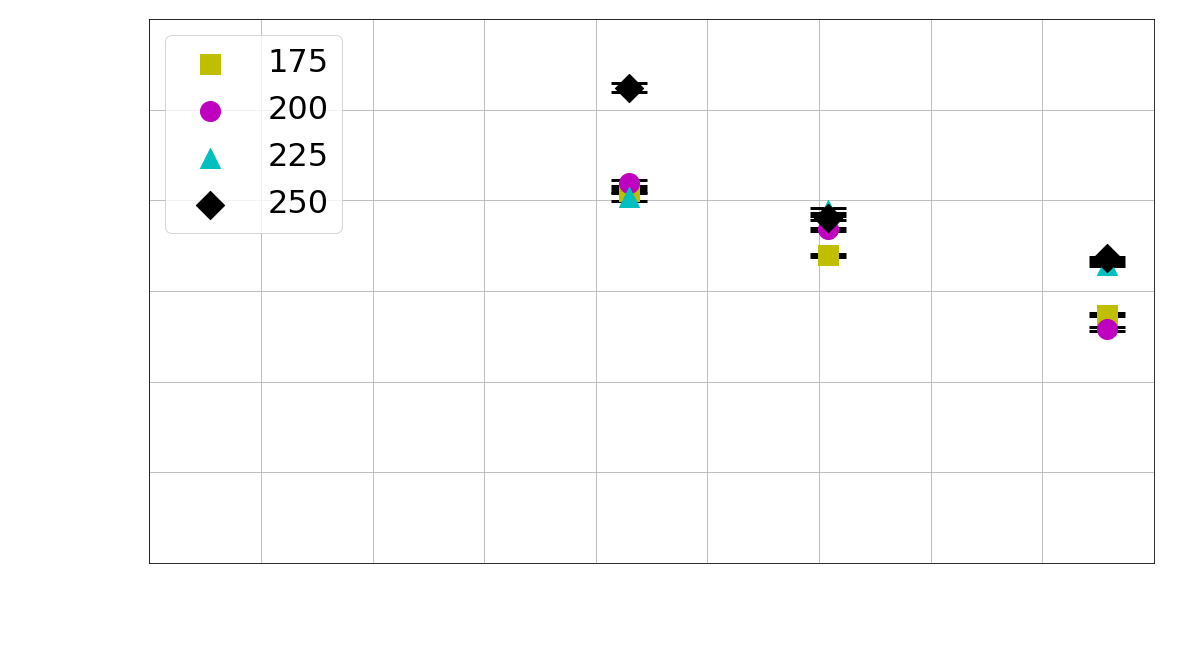

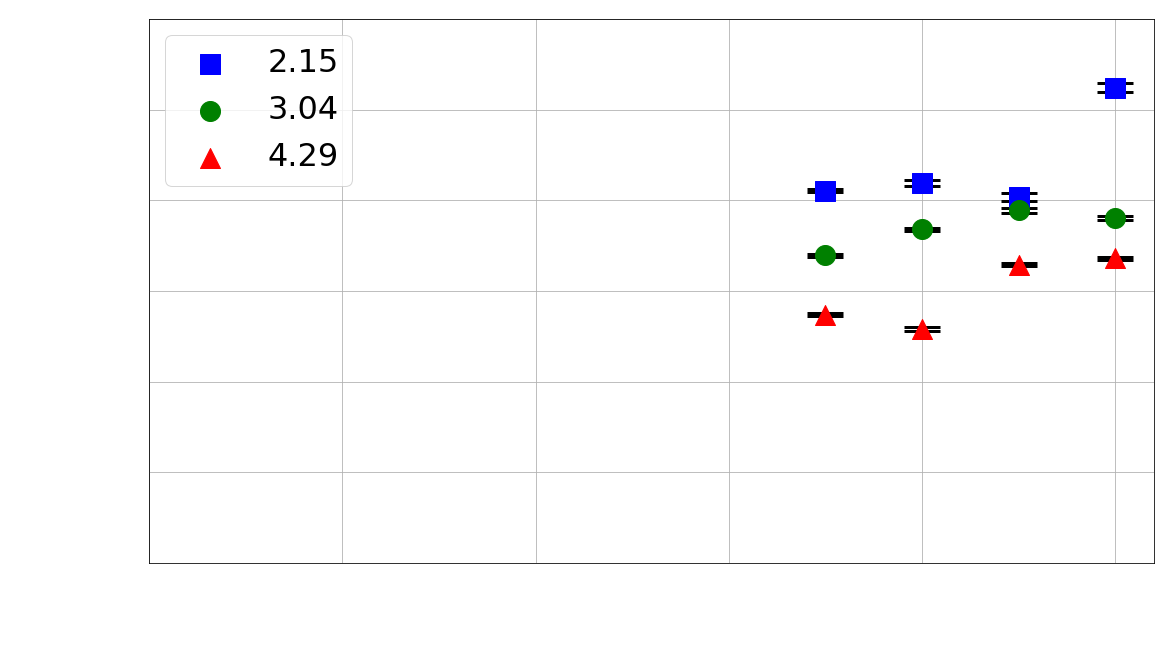

In [75]:
graph_qa_d_180(results[0], results[1])
graph_ua_d_180(results[0], results[1])

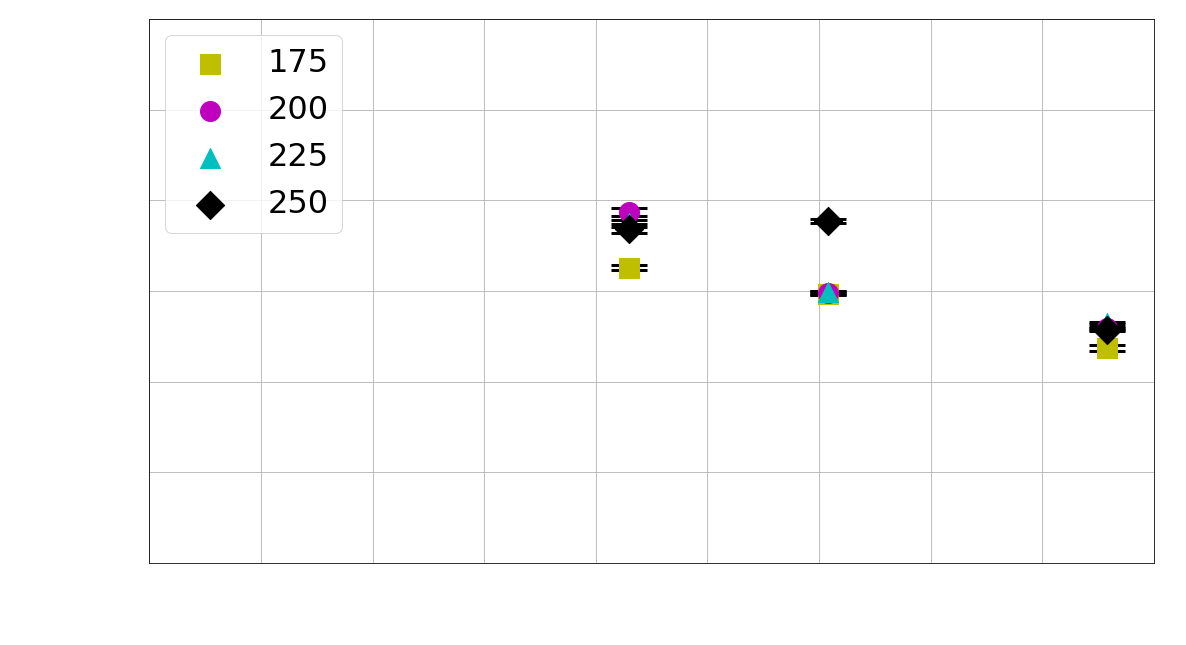

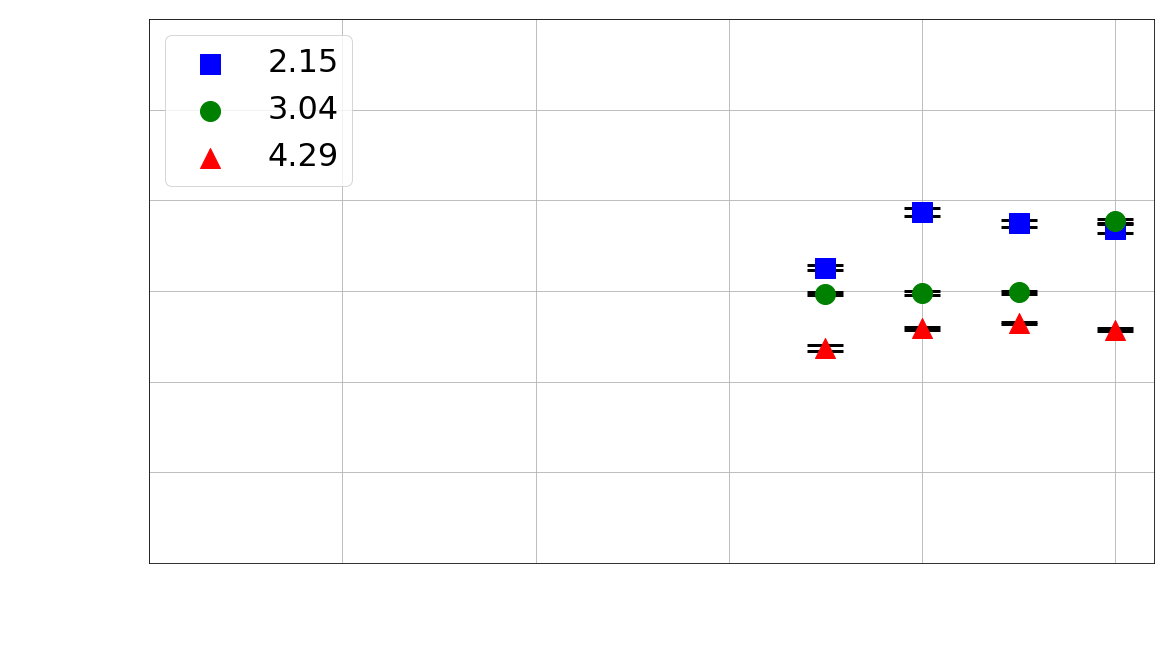

In [76]:
graph_qa_d_240(results[0], results[1])
graph_ua_d_240(results[0], results[1])


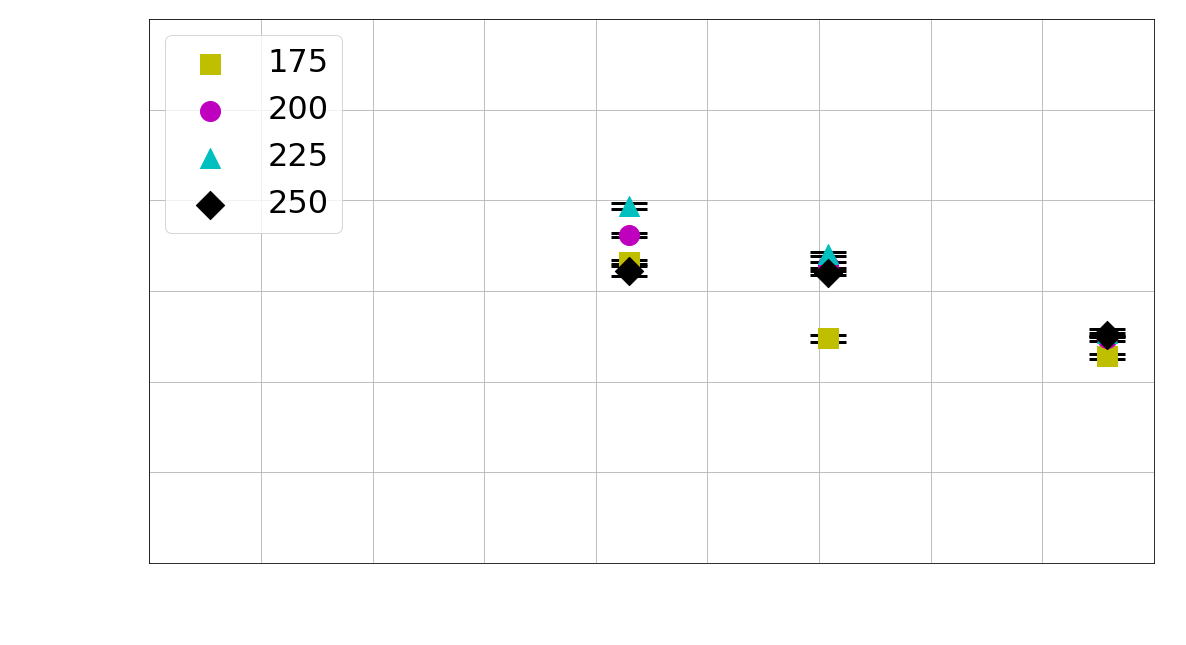

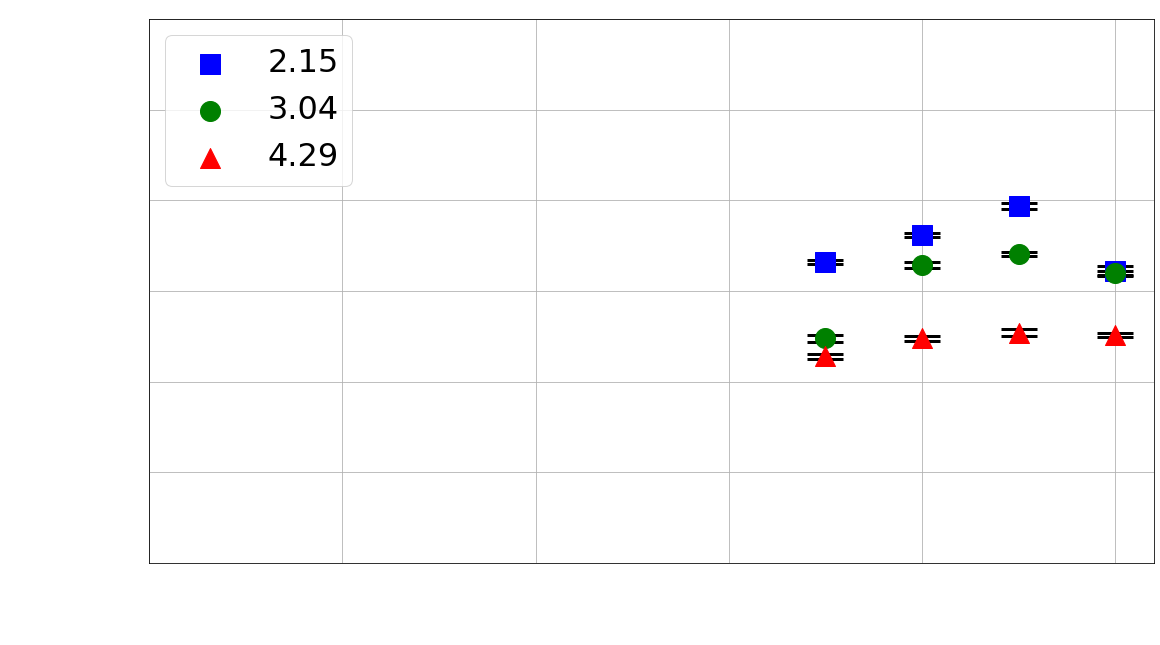

In [77]:
graph_qa_d_300(results[0], results[1])
graph_ua_d_300(results[0], results[1])
